# Split-MNIST Classification Showdown

## 0. Imports and Load Dataset

In [1]:
import jax
from jax import jit, vmap
import jax.numpy as jnp
import jax.random as jr
import flax.linen as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable
from tqdm.notebook import tqdm
from rebayes.utils import datasets
from jax.flatten_util import ravel_pytree
import torchvision
import optax

from rebayes import base
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi

/home/peter0414/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-02-16 16:43:04.187124: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-02-16 16:43:04.187251: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-02-16 16:43:04.187261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with Tens

In [2]:
import hparam_tune_ekf as hp_ekf
import hparam_tune_lofi as hp_lofi

In [3]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["lines.linewidth"] = 2

In [5]:
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True)
images = np.array(mnist_train.data) / 255.0
labels = mnist_train.targets

mnist_test = torchvision.datasets.MNIST(root='./data', train=False)
images_test = np.array(mnist_test.data) / 255.0
labels_test = mnist_test.targets

train = (images, labels)
test = (images_test, labels_test)

In [6]:
X_train, y_train = jnp.expand_dims(jnp.expand_dims(jnp.array(images), -1), 1), jnp.array(labels.ravel()).astype(float)
X_test, y_test = jnp.expand_dims(jnp.expand_dims(jnp.array(images_test), -1), 1), jnp.array(labels_test.ravel()).astype(float)

Generate the Split-MNIST Dataset

In [7]:
train_set_by_digit_pair, test_set_by_digit_pair = {}, {}

for i in range(10//2):
    curr_pair = (2*i, 2*i+1)
    
    # Train set
    train_indx = (y_train == 2*i) | (y_train == 2*i+1)
    train_set_by_digit_pair[str(2*i)+str(2*i+1)] = (X_train[train_indx], y_train[train_indx]-2*i)

    # Test set
    test_indx = (y_test == 2*i) | (y_test == 2*i+1)
    test_set_by_digit_pair[str(2*i)+str(2*i+1)] = (X_test[test_indx], y_test[test_indx]-2*i)

Callback function to evaluate NLL

In [8]:
def nll_callback(bel, *args, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    logits = vmap(jit(apply_fn), (None, 0))(bel.mean, X_test).squeeze()
    nll = jnp.mean(jit(optax.sigmoid_binary_cross_entropy)(logits, y_test))
    
    res = {
        "test": nll,
    }
    return res

In [9]:
def eval_callback(bel, pred, t, X, y, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    logits = vmap(jit(apply_fn), (None, 0))(bel.mean, X_test).squeeze()
    nll_test = jnp.mean(jit(optax.sigmoid_binary_cross_entropy)(logits, y_test))
    
    # One-step-ahead NLL
    nll_ose = jnp.mean(jit(optax.sigmoid_binary_cross_entropy)(y.squeeze(), pred.mean.squeeze()))
    
    res = {
        "nll_test": nll_test,
        "nll_ose": nll_ose,
    }
    return res

# 1. Model Setup

In [10]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x
    
key = jr.PRNGKey(1)
dim_out = 1
dim_in = (28, 28, 1)
model = MLP(dim_out, activation=nn.elu)
params = model.init(key, jnp.ones((1, *dim_in)))
flat_params, unflatten_fn = ravel_pytree(params)
n_params = len(flat_params)
print(f'flat_params.shape: {flat_params.shape}')

# Define apply function
def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

mlp_apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

flat_params.shape: (16141,)


In [11]:
class CNN(nn.Module):
    """A simple CNN model."""
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return x

key = jr.PRNGKey(0)
cnn_model = CNN()
cnn_params = cnn_model.init(key, jnp.ones((1, 28, 28, 1)))
cnn_flat_params, cnn_unflatten_fn = ravel_pytree(cnn_params)
print(f'flat_params.shape: {cnn_flat_params.shape}')

cnn_apply_fn = partial(apply, model=cnn_model, unflatten_fn=cnn_unflatten_fn)

flat_params.shape: (420481,)


In [12]:
sigmoid_fn = lambda w, x: jnp.clip(jax.nn.sigmoid(mlp_apply_fn(w, x)), 1e-4, 1-1e-4).ravel()
emission_mean_function = lambda w, x: sigmoid_fn(w, x)
emission_cov_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))

# 2. FCEKF

## 2.1 Digits (0 & 1) and (2 & 3) (Hyperparams Tuning)

In [13]:
n_warmup_01 = 2_000
n_warmup_23 = 200

X_01_train, y_01_train = train_set_by_digit_pair['01']
X_23_train, y_23_train = train_set_by_digit_pair['23']

X_01_test, y_01_test = test_set_by_digit_pair['01']
X_23_test, y_23_test = test_set_by_digit_pair['23']

X_01_warmup, y_01_warmup = X_01_train[:n_warmup_01], y_01_train[:n_warmup_01]
X_02_warmup, y_02_warmup = X_23_train[:n_warmup_23], y_23_train[:n_warmup_23]

warmup_train = (jnp.concatenate([X_01_warmup, X_02_warmup]), jnp.concatenate([y_01_warmup, y_02_warmup]))
warmup_test = (jnp.concatenate([X_01_test[:n_warmup_23], X_23_test[:n_warmup_01]]), 
                jnp.concatenate([y_01_test[:n_warmup_23], y_23_test[:n_warmup_01]]))

In [14]:
pbounds = {
    "log_init_cov": (-5.0, 0.0),
    "dynamics_weights": (0.0, 1.0),
}

In [15]:
fcekf_optimizer, apply_fn, n_feats = hp_ekf.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, nll_callback, 'fcekf',
    emission_mean_function, emission_cov_function
)

In [28]:
%%time
fcekf_optimizer.maximize(
    init_points=5,
    n_iter=5,
)

|   iter    |  target   | dynami... | log_in... |
-------------------------------------------------


Running for 12,183 iterations: 100%|██████████| 12183/12183 [04:50<00:00, 41.99it/s]


| 26        | -0.6946   | 0.6772    | -1.564    |
| 27        | -0.6932   | 0.4389    | -3.395    |
| 28        | -0.6934   | 0.5706    | -2.601    |
| 29        | -0.6969   | 0.8611    | -0.826    |
| 30        | -0.6932   | 0.1058    | -4.698    |
| 31        | -0.6932   | 0.3618    | -4.123    |
| 32        | -0.6941   | 0.3846    | -1.634    |
| 33        | -0.6958   | 0.1793    | -1.11     |
| 34        | -0.305    | 0.9816    | -0.4639   |
| 35        | -0.6932   | 0.3514    | -4.881    |
CPU times: user 57.2 s, sys: 33.2 s, total: 1min 30s
Wall time: 13min 17s


In [19]:
fcekf_hparams = hp_ekf.get_best_params(n_params, fcekf_optimizer, method="fcekf")
fcekf_hparams.pop('emission_cov_function')
fcekf_estimator = hp_ekf.build_estimator(flat_params, fcekf_hparams, None, mlp_apply_fn, method="fcekf", 
                                         emission_mean_function=emission_mean_function,
                                         emission_cov_function=emission_cov_function)

In [20]:
bel_fcekf = fcekf_estimator.init_bel()

## 2.2 Digits 4 & 5

In [21]:
# n_train = 1_000
X_45_train, y_45_train = train_set_by_digit_pair['45']
# X_45_train, y_45_train = X_45_train[:n_train], y_45_train[:n_train]
X_45_test, y_45_test = test_set_by_digit_pair['45']

In [22]:
test_45_kwargs = {"X_test": X_45_test, "y_test": y_45_test, "apply_fn": mlp_apply_fn}

In [23]:
bel_45_fcekf, output_45_fcekf = fcekf_estimator.scan(
    X_45_train, y_45_train, callback=eval_callback, bel=bel_fcekf, progress_bar=True, **test_45_kwargs
)

Running for 11,263 iterations: 100%|█████████▉| 11260/11263 [04:14<00:00, 41.98it/s]

Running for 11,263 iterations: 100%|██████████| 11263/11263 [04:28<00:00, 41.96it/s]


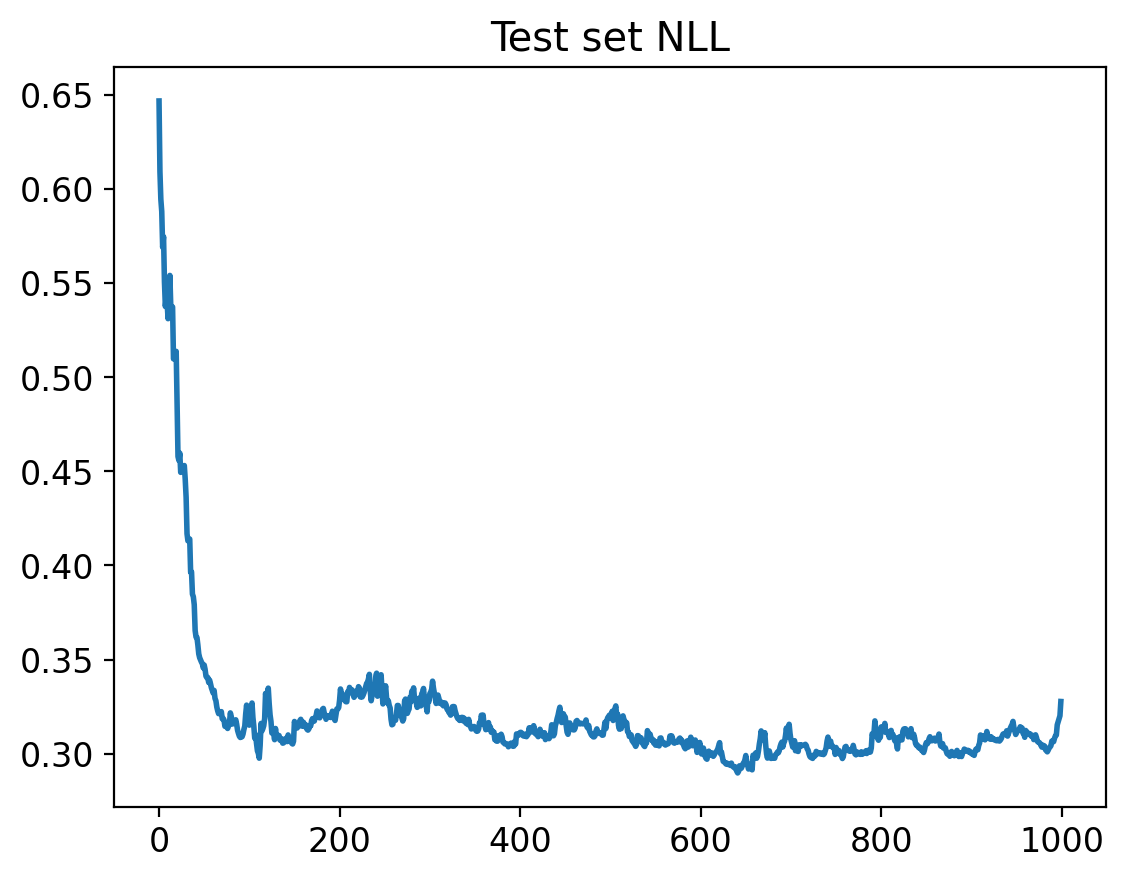

In [24]:
fig, ax = plt.subplots()
# Plot the first 1000 steps
ax.plot(output_45_fcekf['nll_test'][:1000]);
ax.set_title('Test set NLL');

## 2.3 Digits 6 & 7

In [25]:
# n_train = 1_000
X_67_train, y_67_train = train_set_by_digit_pair['67']
# X_67_train, y_67_train = X_67_train[:n_train], y_67_train[:n_train]
X_67_test, y_67_test = test_set_by_digit_pair['67']

In [26]:
test_67_kwargs = {"X_test": X_67_test, "y_test": y_67_test, "apply_fn": mlp_apply_fn}

In [27]:
bel_67_fcekf, output_67_fcekf = fcekf_estimator.scan(
    X_67_train, y_67_train, callback=eval_callback, bel=bel_45_fcekf, progress_bar=True, **test_67_kwargs
)

Running for 12,183 iterations:  15%|█▍        | 1827/12183 [00:29<02:54, 59.29it/s]

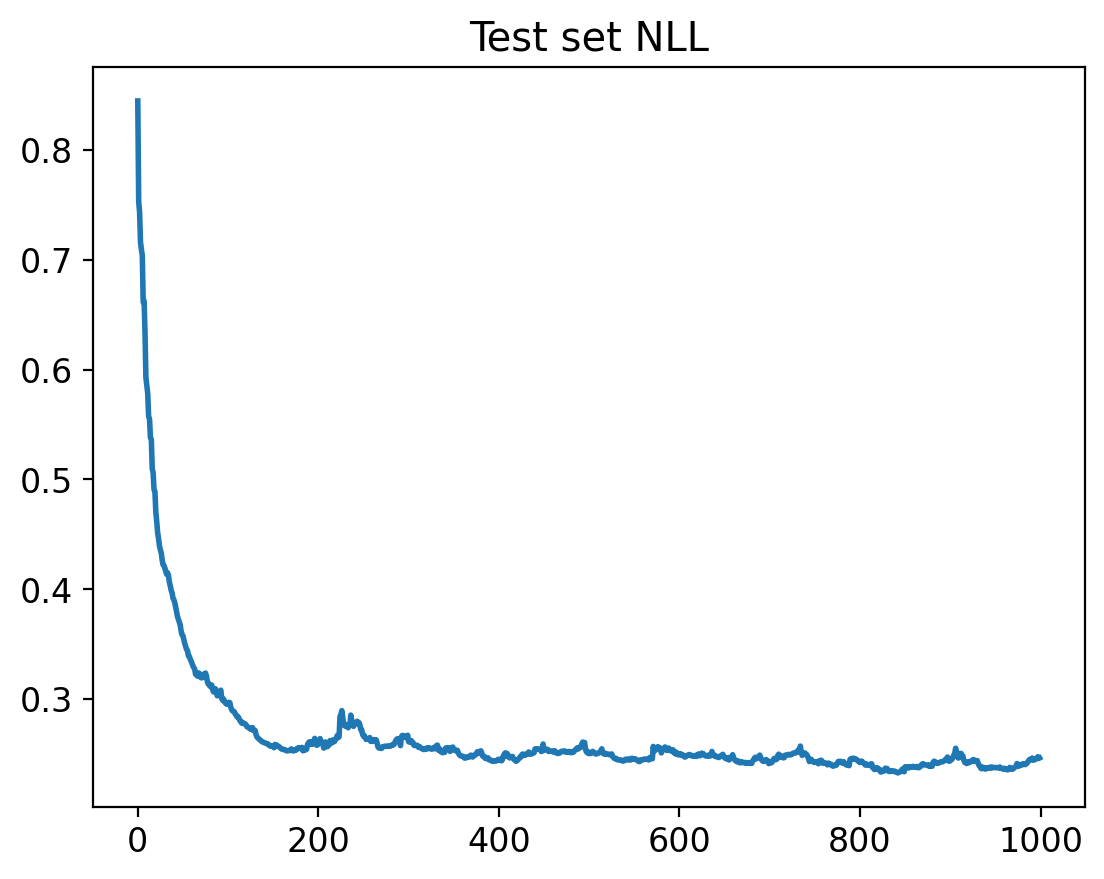

In [42]:
fig, ax = plt.subplots()
ax.plot(output_67_fcekf['nll_test'][:1000]);
ax.set_title('Test set NLL');

## 2.4 Digits 8 & 9

In [43]:
n_train = 1_000
X_89_train, y_89_train = train_set_by_digit_pair['89']
X_89_train, y_89_train = X_89_train[:n_train], y_89_train[:n_train]
X_89_test, y_89_test = test_set_by_digit_pair['89']

In [44]:
test_89_kwargs = {"X_test": X_89_test, "y_test": y_89_test, "apply_fn": mlp_apply_fn}

In [45]:
bel_89_fcekf, output_89_fcekf = fcekf_estimator.scan(
    X_89_train, y_89_train, callback=eval_callback, bel=bel_67_fcekf, progress_bar=True, **test_89_kwargs
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:23<00:00, 41.98it/s]


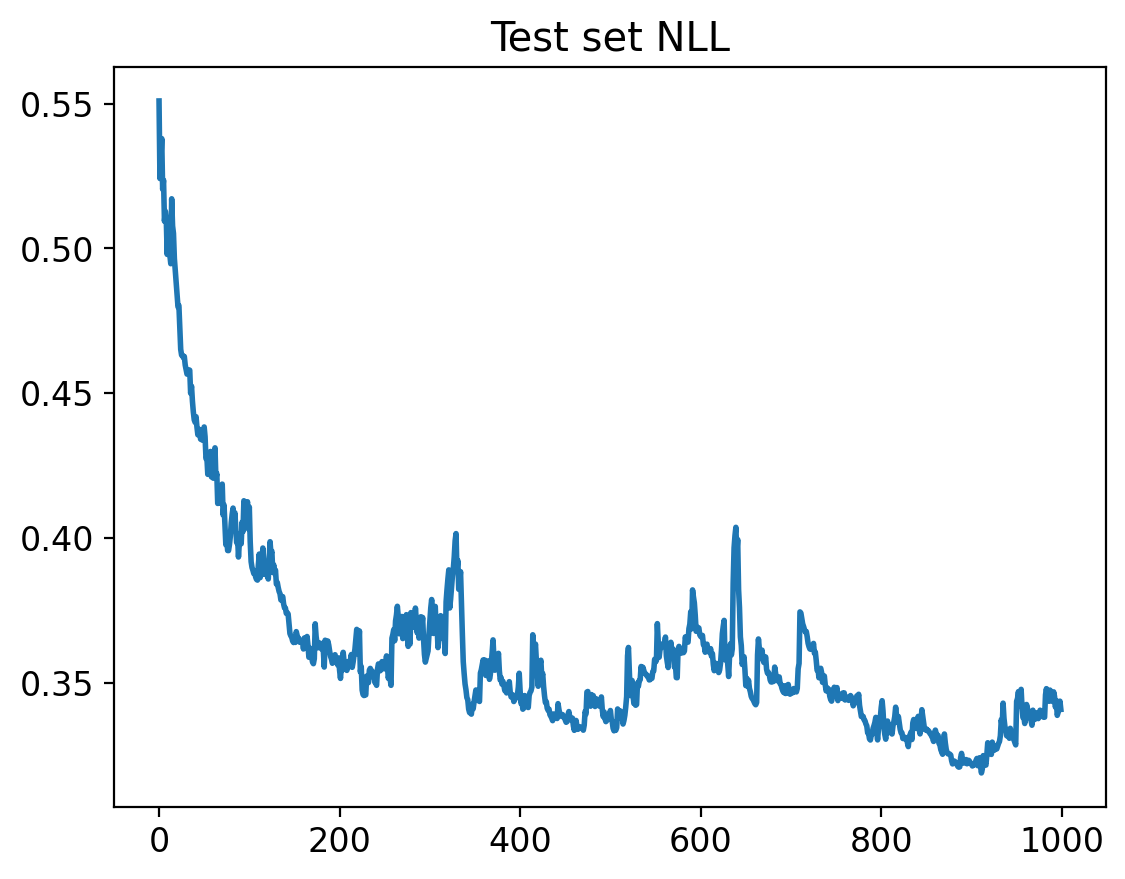

In [46]:
fig, ax = plt.subplots()
ax.plot(output_89_fcekf['nll_test']);
ax.set_title('Test set NLL');

# 3. FDEKF

## 3.1 Hyperparameter Tuning

In [47]:
fdekf_optimizer, apply_fn, n_feats = hp_ekf.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, nll_callback, 'fdekf',
    emission_mean_function, emission_cov_function
)

In [48]:
%%time
fdekf_optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_in... |
-------------------------------------------------
| 1         | -0.6934   | 0.9169    | -2.057    |
| 2         | -0.6957   | 0.265     | -1.084    |
| 3         | -0.6953   | 0.918     | -0.8632   |
| 4         | -0.6932   | 0.728     | -3.698    |
| 5         | -0.6932   | 0.9118    | -3.696    |
| 6         | -0.6932   | 0.7664    | -3.692    |
| 7         | -0.6933   | 0.1223    | -3.07     |
| 8         | -0.6932   | 0.8401    | -3.609    |
| 9         | -0.6941   | 0.06991   | -1.834    |
| 10        | -0.6937   | 0.5848    | -2.094    |
| 11        | -0.6932   | 0.0       | -5.0      |
| 12        | -0.259    | 1.0       | -5.0      |
| 13        | -0.325    | 0.9991    | -4.753    |
| 14        | -0.6932   | 0.8909    | -4.998    |
| 15        | -0.6932   | 0.9929    | -4.957    |
| 16        | -0.6932   | 0.994     | -4.741    |
| 17        | -0.6932   | 0.7032    | -3.891    |
| 18        | -0.6932   | 0.8322    | -4.716    |


In [49]:
fdekf_hparams = hp_ekf.get_best_params(n_params, fdekf_optimizer, method="fdekf")
fdekf_hparams.pop('emission_cov_function')
fdekf_estimator = hp_ekf.build_estimator(flat_params, fdekf_hparams, None, mlp_apply_fn, method="fdekf",
                                         emission_mean_function=emission_mean_function,
                                         emission_cov_function=emission_cov_function)

In [50]:
bel_fdekf = fdekf_estimator.init_bel()

## 3.2 Digits 4 & 5

In [52]:
bel_45_fdekf, output_45_fdekf = fdekf_estimator.scan(
    X_45_train, y_45_train, callback=eval_callback, bel=bel_fdekf, progress_bar=True, **test_45_kwargs
)

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:00<00:00, 9524.18it/s]


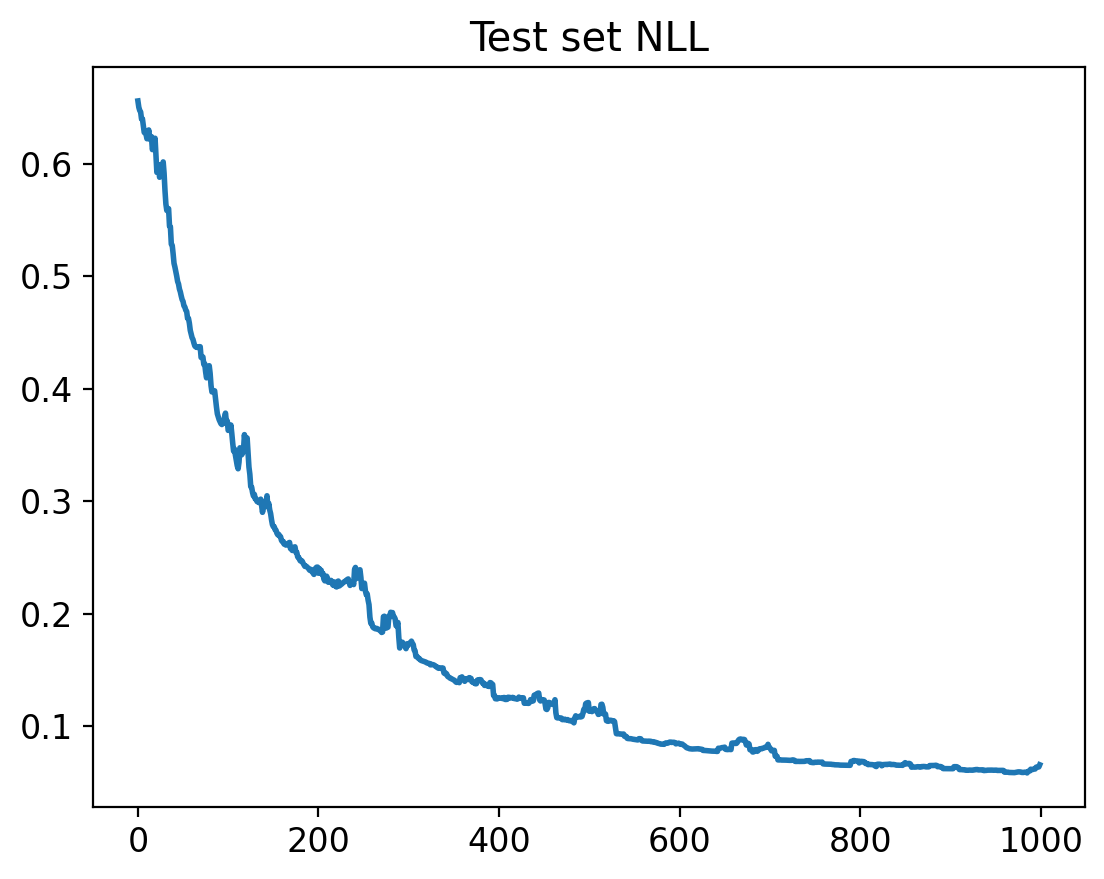

In [53]:
fig, ax = plt.subplots()
ax.plot(output_45_fdekf['nll_test']);
ax.set_title('Test set NLL');

## 3.3 Digits 6 & 7

In [54]:
bel_67_fdekf, output_67_fdekf = fdekf_estimator.scan(
    X_67_train, y_67_train, callback=eval_callback, bel=bel_45_fdekf, progress_bar=True, **test_67_kwargs
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:00<00:00, 9150.54it/s]


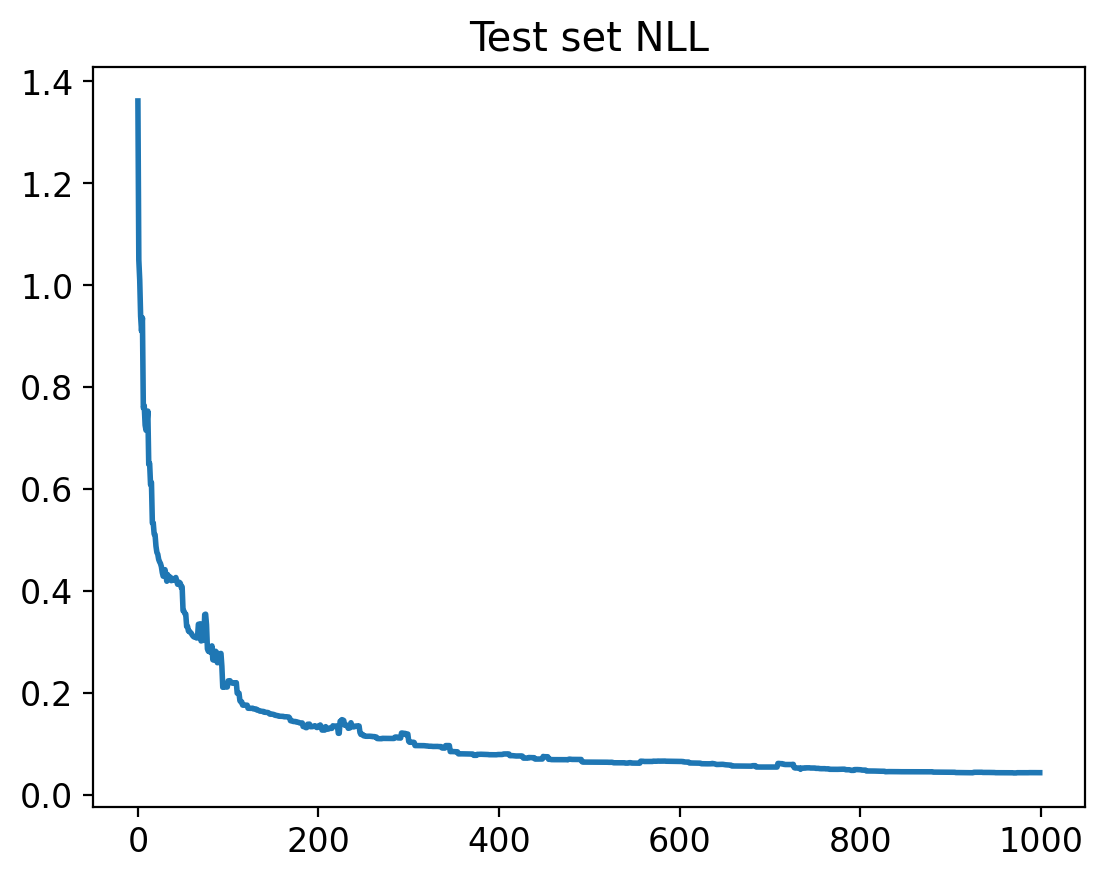

In [55]:
fig, ax = plt.subplots()
ax.plot(output_67_fdekf['nll_test']);
ax.set_title('Test set NLL');

## 3.4 Digits 8 & 9

In [56]:
bel_89_fdekf, output_89_fdekf = fdekf_estimator.scan(
    X_89_train, y_89_train, callback=eval_callback, bel=bel_67_fdekf, progress_bar=True, **test_89_kwargs
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:00<00:00, 9207.28it/s]


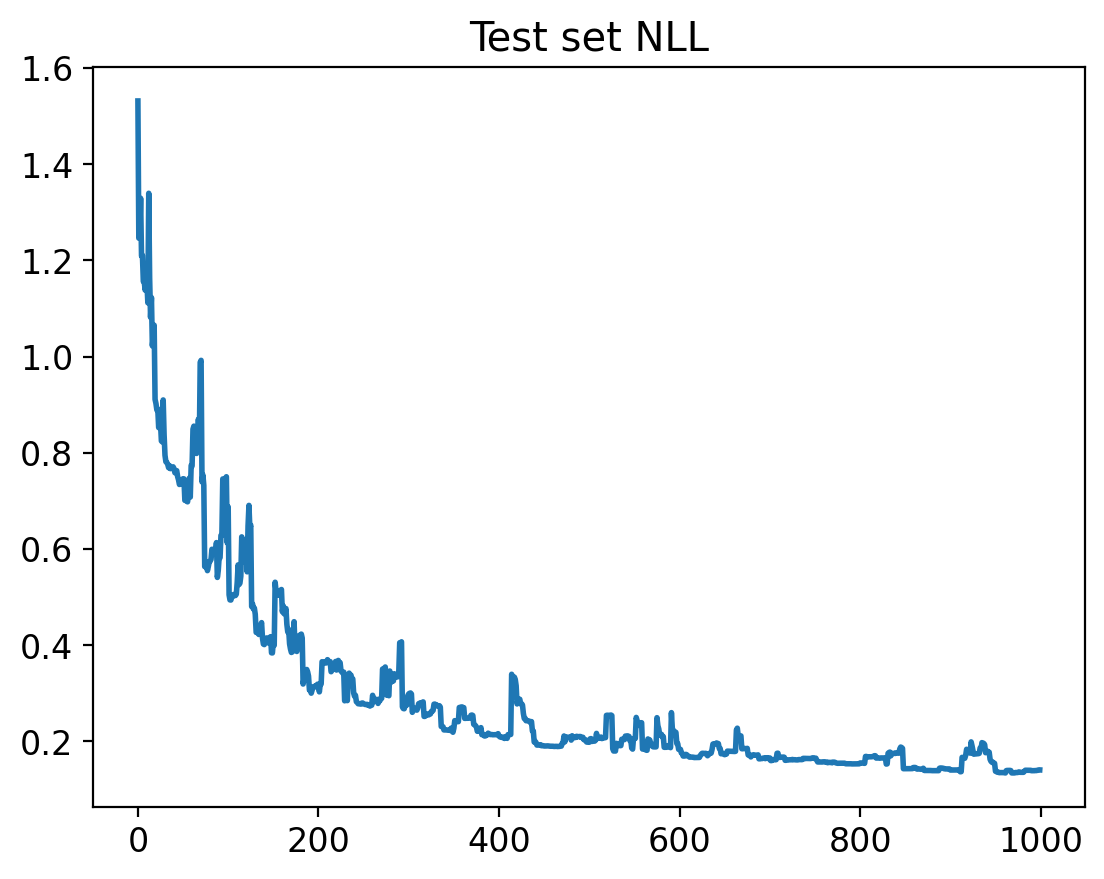

In [61]:
fig, ax = plt.subplots()
ax.plot(output_89_fdekf['nll_test']);
ax.set_title('Test set NLL');

# 4. Orth-LoFi

## 4.1 Hyperparameter Tuning

In [72]:
method = "orth_svd_lofi"
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
    adaptive_variance=False,
)

orth_lofi_optimizer, apply_fn, n_features = hp_lofi.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, params_lofi, nll_callback, method,
    emission_mean_function, emission_cov_function,
)

In [73]:
%%time
orth_lofi_optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_in... |
-------------------------------------------------
| 1         | -0.6935   | 0.9169    | -2.057    |
| 2         | -0.6954   | 0.265     | -1.084    |
| 3         | -0.6975   | 0.918     | -0.8632   |
| 4         | -0.6931   | 0.728     | -3.698    |
| 5         | -0.6931   | 0.9118    | -3.696    |
| 6         | -0.6932   | 0.7664    | -3.692    |
| 7         | -0.6933   | 0.1223    | -3.07     |
| 8         | -0.6932   | 0.8401    | -3.609    |
| 9         | -0.6941   | 0.06991   | -1.834    |
| 10        | -0.6933   | 0.5848    | -2.094    |
| 11        | -0.6932   | 0.0       | -4.604    |
| 12        | -0.2619   | 1.0       | -5.0      |
| 13        | -0.6931   | 0.8452    | -4.986    |
| 14        | -0.6932   | 0.9798    | -4.971    |
| 15        | -0.6932   | 0.7346    | -3.107    |
| 16        | -0.6936   | 0.2276    | -2.065    |
| 17        | -0.6932   | 0.7032    | -3.891    |
| 18        | -0.6931   | 0.8322    | -4.716    |


In [74]:
orth_lofi_hparams = hp_lofi.get_best_params(n_params, orth_lofi_optimizer)
orth_lofi_hparams.pop('emission_cov_function')
orth_lofi_estimator = hp_lofi.build_estimator(flat_params, orth_lofi_hparams, params_lofi,
                                              mlp_apply_fn, method, emission_mean_function,
                                              emission_cov_function,)

In [75]:
bel_orth_lofi = orth_lofi_estimator.init_bel()

## 4.2 Digits 4 & 5

In [76]:
bel_45_orth_lofi, output_45_orth_lofi = orth_lofi_estimator.scan(
    X_45_train, y_45_train, callback=eval_callback, bel=bel_orth_lofi, progress_bar=True, **test_45_kwargs
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1942.79it/s]


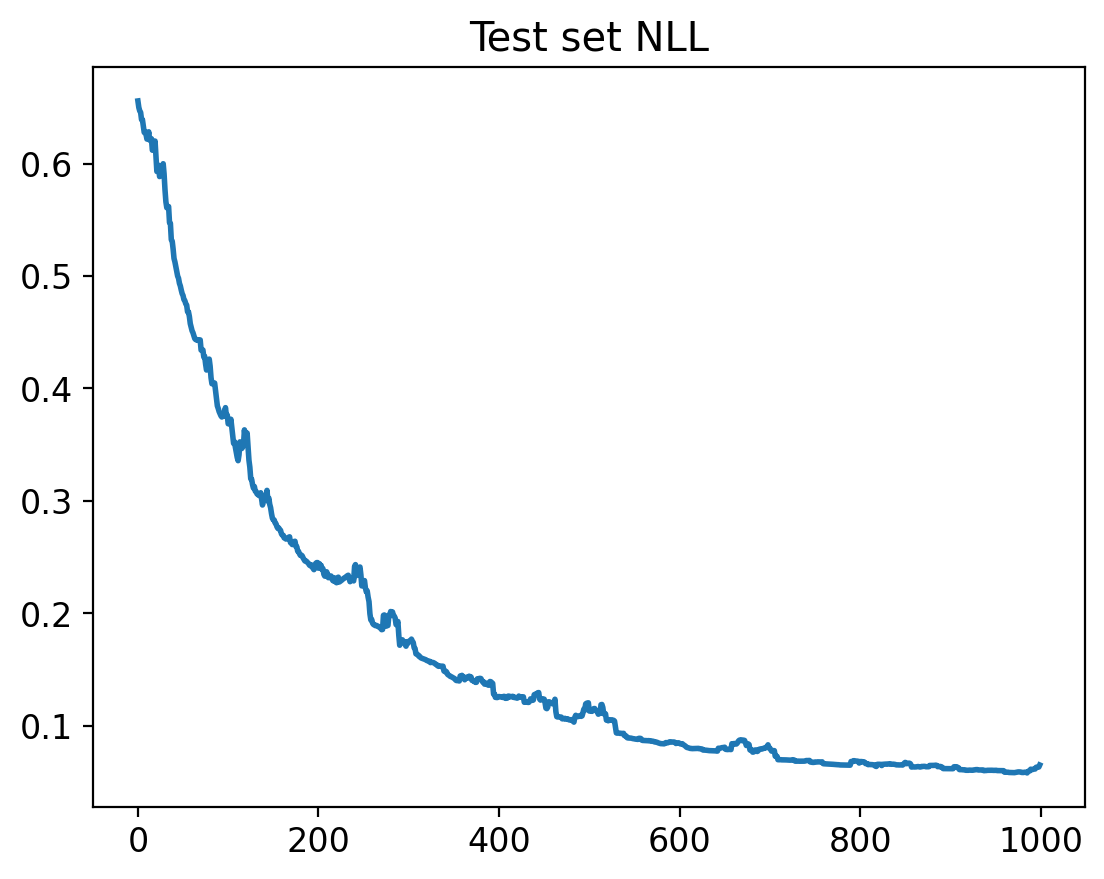

In [79]:
fig, ax = plt.subplots()
ax.plot(output_45_orth_lofi['nll_test']);
ax.set_title('Test set NLL');

## 4.3 Digits 6 & 7

In [80]:
bel_67_orth_lofi, output_67_orth_lofi = orth_lofi_estimator.scan(
    X_67_train, y_67_train, callback=eval_callback, bel=bel_45_orth_lofi, progress_bar=True, **test_67_kwargs
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1927.37it/s]


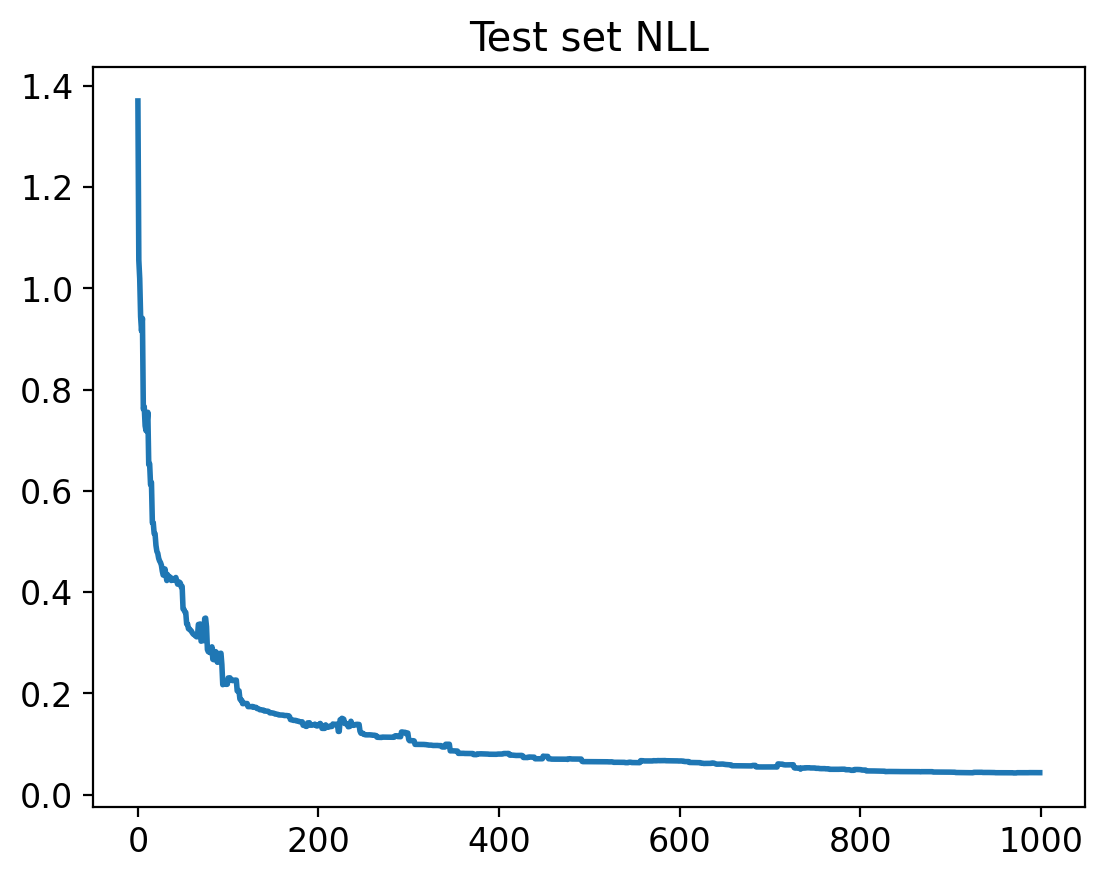

In [83]:
fig, ax = plt.subplots()
ax.plot(output_67_orth_lofi['nll_test']);
ax.set_title('Test set NLL');

## 4.4 Digits 8 & 9

In [84]:
bel_89_orth_lofi, output_89_orth_lofi = orth_lofi_estimator.scan(
    X_89_train, y_89_train, callback=eval_callback, bel=bel_67_orth_lofi, progress_bar=True, **test_89_kwargs
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1926.85it/s]


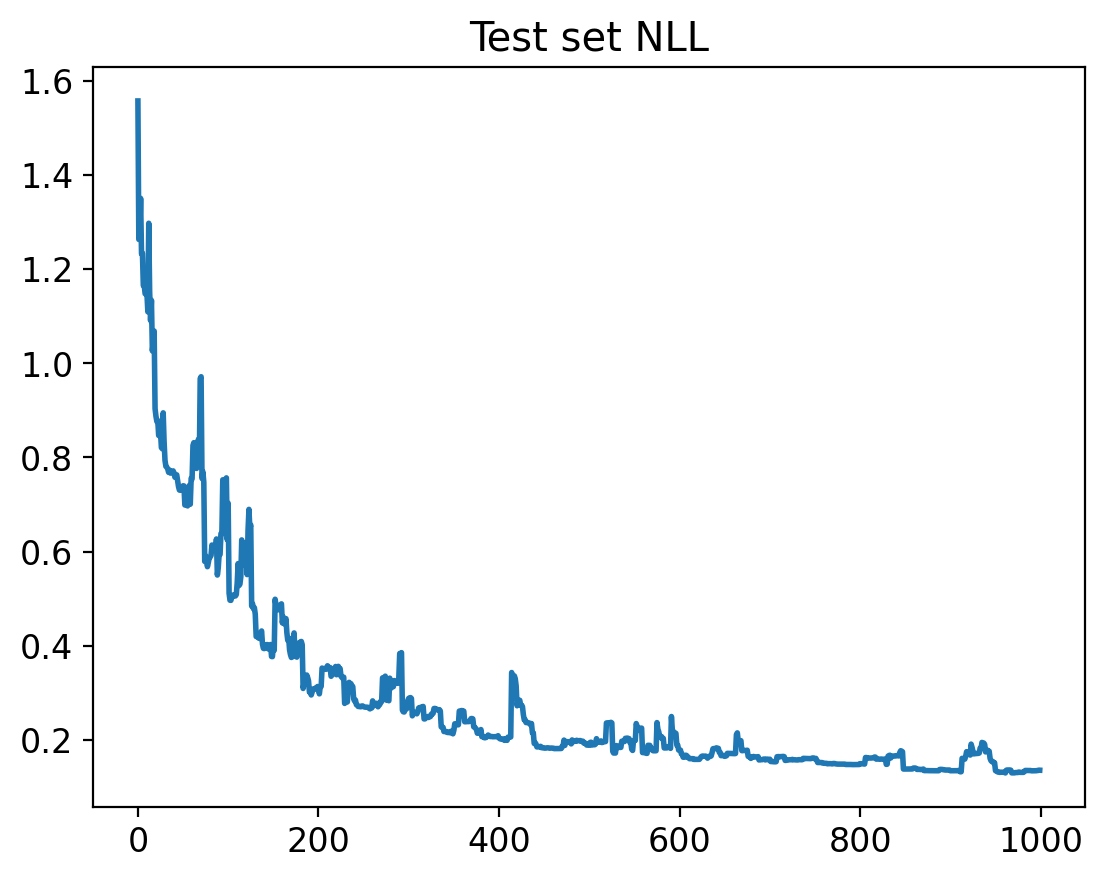

In [87]:
fig, ax = plt.subplots()
ax.plot(output_89_orth_lofi['nll_test']);
ax.set_title('Test set NLL');

# 5. Full-LoFi

## 5.1 Hyperparameter Tuning

In [88]:
method = "full_svd_lofi"
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
    adaptive_variance=False,
)

full_lofi_optimizer, apply_fn, n_features = hp_lofi.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, params_lofi, nll_callback, method,
    emission_mean_function, emission_cov_function,
)

In [89]:
%%time
full_lofi_optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_in... |
-------------------------------------------------
| 1         | -0.6934   | 0.9169    | -2.057    |
| 2         | -0.6957   | 0.265     | -1.084    |
| 3         | -0.5797   | 0.918     | -0.8632   |
| 4         | -0.6932   | 0.728     | -3.698    |
| 5         | -0.6932   | 0.9118    | -3.696    |
| 6         | -0.6932   | 0.7664    | -3.692    |
| 7         | -0.6933   | 0.1223    | -3.07     |
| 8         | -0.6932   | 0.8401    | -3.609    |
| 9         | -0.6941   | 0.06991   | -1.834    |
| 10        | -0.6937   | 0.5848    | -2.094    |
| 11        | -18.34    | 1.0       | -0.4971   |
| 12        | -0.6952   | 0.8449    | -1.252    |
| 13        | -0.7015   | 0.01214   | -0.5774   |
| 14        | -0.6935   | 0.06452   | -2.459    |
| 15        | -0.6934   | 0.6218    | -2.708    |
| 16        | -0.6932   | 0.03651   | -3.663    |
| 17        | -0.6932   | 0.7032    | -3.891    |
| 18        | -0.6932   | 0.8322    | -4.716    |


In [90]:
full_lofi_hparams = hp_lofi.get_best_params(n_params, full_lofi_optimizer)
full_lofi_hparams.pop('emission_cov_function')
full_lofi_estimator = hp_lofi.build_estimator(flat_params, full_lofi_hparams, params_lofi,
                                              mlp_apply_fn, method, emission_mean_function,
                                              emission_cov_function,)

In [91]:
bel_full_lofi = full_lofi_estimator.init_bel()

## 5.2 Digits 4 & 5

In [92]:
bel_45_full_lofi, output_45_full_lofi = full_lofi_estimator.scan(
    X_45_train, y_45_train, callback=eval_callback, bel=bel_full_lofi, progress_bar=True, **test_45_kwargs
)

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:03<00:00, 325.80it/s]


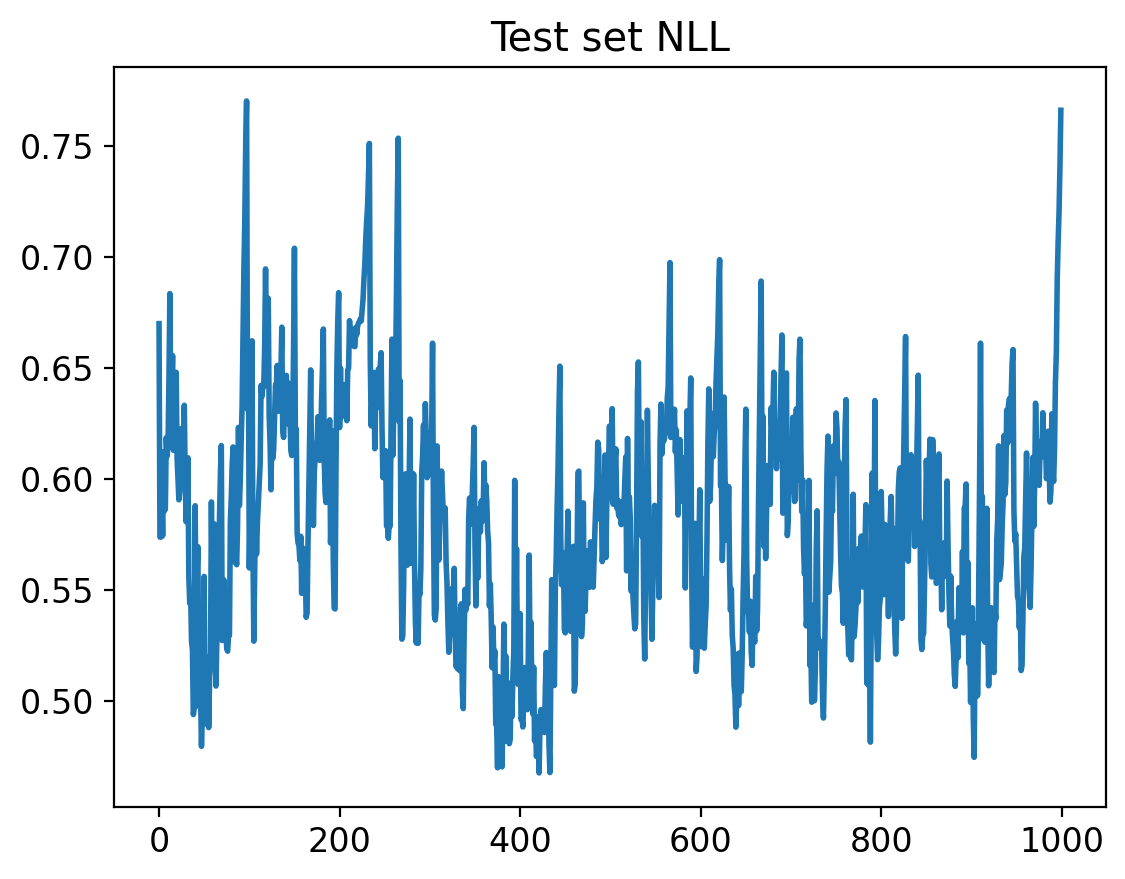

In [93]:
fig, ax = plt.subplots()
ax.plot(output_45_full_lofi['nll_test']);
ax.set_title('Test set NLL');